# TP 2 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [3]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...


  No Changes to `C:\Users\elgue\OneDrive\Bureau\SN\2SN\S7\RO\Notebook+InstancesTP2\Project.toml`
  No Changes to `C:\Users\elgue\OneDrive\Bureau\SN\2SN\S7\RO\Notebook+InstancesTP2\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\elgue\OneDrive\Bureau\SN\2SN\S7\RO\Notebook+InstancesTP2\Project.toml`
  No Changes to `C:\Users\elgue\OneDrive\Bureau\SN\2SN\S7\RO\Notebook+InstancesTP2\Manifest.toml`

### Récupération des données

In [4]:
function readKnaptxtInstance(filename)
    price=Int64[]
    weight=Int64[]
    KnapCap=Int64[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [5]:
function testSondability_LP( capacity,  borne, BestProfit, Bestsol)
   
    TA, TO, TR = false, false, false
    
    

    if capacity < 0  # Test d'Admissibilité
        TA = true
        
        println("TA")
        
    elseif (borne < BestProfit)  # Test d'optimalite
        TO = true
        
        println("TO")
        
    elseif (capacity == 0) || (borne == BestProfit)  # Test de resolution
        TR = true
        
        println("TR")
       
        
    else
        
        println("non sondable")
        
    end
    return TA, TO, TR, Bestsol, BestProfit
end

testSondability_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [6]:
function separateNodeThenchooseNext_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left

    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end

    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function exploreNextNode_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible

    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop
end

exploreNextNode_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [7]:
function Bornes(price,weight, capacity, listobjs,listvals, BestProfit, Bestsol, option)
    
    
    borne = 0
    prix = 0
    max = 0

    
    if option == 1
        weightAct = 0
        priceAct = 0
        for i in 1:length(listobjs)
            if listvals[i] == 1
                weightAct += weight[listobjs[i]]
                priceAct += price[listobjs[i]]
            end
                   
        end
    
        if priceAct >= BestProfit
            Bestsol = copy(listobjs)
            BestProfit = priceAct
        end
            
        if (length(listobjs) < length(price))
                
            for i in (length(listobjs)+1):length(price)
                r = price[i]/weight[i]
                if (!(i in listobjs)) 
                    if r > max        
                        max = r
                
                   end     
                
                end
            end
                
            borne = priceAct + max*capacity
            
        else
            
            borne = priceAct
            
        end
        
    elseif option == 2
        for i in 1:length(listobjs)
            if listvals[i] == 1
                capacity = capacity - weight[listobjs[i]]
                println("capacity2 =", capacity)
                prix = prix + price[listobjs[i]]
                
            end
        end
    
        deleteat!(price, listobjs)
        deleteat!(weight, listobjs)
    
        if capacity >= 0
            if prix > BestProfit
                BestProfit = prix
                Bestsol= copy(listobjs)
            end
        end
        
        
        #ration
        r = price./weight
        listR = [(r[i], weight[i]) for i in 1:length(price)]
        listR = sort(listR, by = x -> x[1], rev=true)
        prix1 = 0

        for i in 1:length(listR)
            if listR[i][2] <= capacity
                prix1 = prix1 + listR[i][1]*listR[i][2]
                capacity = capacity - listR[i][2]
            else
                break
            end
        end

        borne = prix + prix1
    end
         
return borne, capacity, BestProfit, Bestsol
        
end

Bornes (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [13]:
function solveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)
    n = length(price)

    #model2, x = createModel_LP(price, weight, capacity)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=Int64[]
    listvals=Float64[]
    listnodes=Int64[]

    BestProfit::Float64=-1.0
    Bestsol=Float64[]

    current_node_number::Int64=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        
        #create LP of current node
        #updateModele_LP!(model2, x, listobjs, listvals)
        
        #println(model2)
        
        print("Solve the LP model of the current node to compute its bound: start ... ")

        #status = optimize!(model2)

        
        priceAct = deepcopy(price)
        weightAct = deepcopy(weight)
        capacityAct = capacity

       
        option = 2
        
        borne, capacityAc, Bestp, BestS = Bornes(priceAct, weightAct, capacityAct, listobjs,listvals, BestProfit, Bestsol, option)

        BestProfit = Bestp

        Bestsol = BestS



        TA, TO, TR = testSondability_LP( capacityAc,  borne, Bestp, BestS)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            separateNodeThenchooseNext_lexicographic_depthfirst!(listobjs, listvals, length(price))
        else
            stop = exploreNextNode_depthfirst!(listobjs, listvals, listnodes)
        end
        
        #resetAll_LP!(model2, x)

        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


solveKnapInstance (generic function with 1 method)

### Affichage du résultat final

In [14]:
function solveNdisplayKnap(filename)

    println("\n Branch-and-Bound for solving a knapsack problem. \n\n Solving instance '" * filename * "'\n")

    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = solveKnapInstance(filename)

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

end

solveNdisplayKnap (generic function with 1 method)


 Branch-and-Bound for solving a knapsack problem. 

 Solving instance 'InstancesKnapSack/test.opb.txt'


Node number 0: 
---------------



Solve the LP model of the current node to compute its bound: start ... non sondable

branch on object 1


Node number 1: 
---------------

Solve the LP model of the current node to compute its bound: start ... capacity2 =3
TR

Node number 2: 
---------------

Solve the LP model of the current node to compute its bound: start ... non sondable

branch on object 2


Node number 3: 
---------------

Solve the LP model of the current node to compute its bound: start ... capacity2 =6
non sondable

branch on object 3


Node number 4: 
---------------

Solve the LP model of the current node to compute its bound: start ... capacity2 =6
capacity2 =3
TR

Node number 5: 
---------------

Solve the LP model of the current node to compute its bound: start ... capacity2 =6
non sondable

branch on object 4


Node number 6: 
---------------

Solve the LP model of the current node to compute its bound: start ... capacity2 =6
capacity2 =1

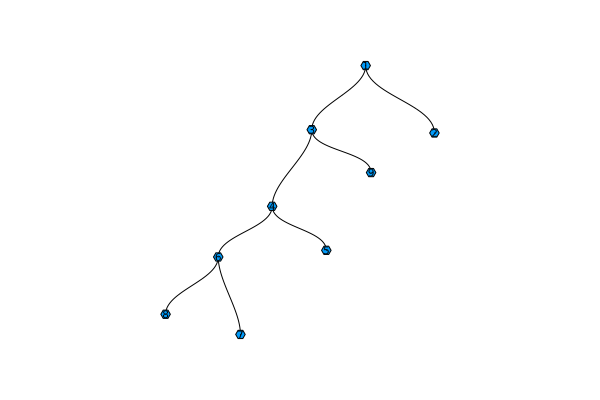


TR

Node number 7: 
---------------

Solve the LP model of the current node to compute its bound: start ... capacity2 =6
TO

Node number 8: 
---------------

Solve the LP model of the current node to compute its bound: start ... TO

FINISHED

******

Optimal value = 65.0

Optimal x=[1, 2, 3, 4]

******

Optimal value = 65.0

Optimal x=[1, 2, 3, 4]

 Branch-and-bound tree visualization : start display ...


... end display. 


press enter to exit ! 


UndefVarError: UndefVarError: `execute_msg` not defined

In [15]:
INSTANCE = "InstancesKnapSack/test.opb.txt"

solveNdisplayKnap(INSTANCE)

println("press enter to exit ! ")
readline()


Questions préliminaires

1- la réglede séparation choisie est la régle de séparation lexicographique, qui consiste à choisir le premier objet qui n'a pas encore pris.

2- La borne supérieure est obtenue en résolvant la relaxation linéaire du problème, en fixant les variables à 1 pour les objets pris et 0 pour celle non pris.

3- TA : Admissible si la relaxation linéaire a une solution.
TO : solution Relaxation linéaire est inférieur profit maximal.
TR : Relaxation linéaire atteinte par valeurs entières.

4- La méthode d'exploration utilisée est la stratégie de recherche en profondeur, également appelée la stratégie depthfirst.


Code et Analyses

1 et 2 - Regardez le code Bornes

3- Règle de Séparation : Nous avons maintenu l'ordre lexicographique initial dans notre implémentation du Branch-and-Bound.

Test de Faisabilité (TA) : Le test  est réussi lorsque la capacité du sac à dos devient négative. c'est à dire le sac est remplie plus que sa capacité normal.

Test d'Optimalité (TO) : Le test réussit si la valeur de la borne supérieure, obtenue en remplissant le sac à dos, est inférieure à la meilleure solution déjà identifiée.

Test de Relaxation (TR) : Le test de relaxation est réussi lorsque nous identifions une solution évidente au problème. Nous l'avons validé en cas de capacité nulle du sac à dos au nœud sondé, ou on trouve la même solution qu'on a trouvé avant.

Stratégie d'Exploration : Nous avons conservé la stratégie d'exploration en profondeur (deephtfirst) .

4- 